In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from minepy import MINE  # 计算 MIC（最大信息系数）
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# 读取数据
file_path = 'cleaned_data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')



In [4]:
# 查看列名
column_names = data.columns
print(column_names)

Index(['Fe', 'Co', 'Mn', 'Al', 'Ni', 'B', 'Hf', 'Si', 'Cu', 'P', 'Mo', 'Cr',
       'La', 'Ti', 'Sn', 'V', 'Ga', 'Nb', 'Zr', 'C', 'Gd', 'Y', 'Ta', 'DO3',
       'BCC', 'FCC', 'HCP', 'Orthorhombic', 'hexagonal', 'Tetragonal',
       'Primitive Cubic', 'Ms', 'Hc', 'Hc_log'],
      dtype='object')


In [5]:
# 定义特征
element_columns = ['Fe', 'Co', 'Mn', 'Al', 'Ni', 'B', 'Hf', 'Si', 'Cu', 'P', 'Mo', 'Cr',
       'La', 'Ti', 'Sn', 'V', 'Ga', 'Nb', 'Zr', 'C', 'Gd', 'Y', 'Ta']
crystal_phase_columns = ['DO3',
       'BCC', 'FCC', 'HCP', 'Orthorhombic', 'hexagonal', 'Tetragonal',
       'Primitive Cubic']
target_columns = ['Ms', 'Hc']

In [6]:
# 选择需要计算的列
feature_columns = element_columns + crystal_phase_columns + target_columns
data = data[feature_columns]  # 只保留这些列

# 计算 MIC 相关性矩阵
def calculate_mic_matrix(df):
    """ 计算 MIC 相关性矩阵 """
    mic_matrix = np.zeros((df.shape[1], df.shape[1]))  # 初始化矩阵
    mine = MINE(alpha=0.6, c=15)  # 设置 MIC 参数
    
    for i in range(df.shape[1]):
        for j in range(i, df.shape[1]):  # 只计算上三角
            if i == j:
                mic_matrix[i, j] = 1  # 对角线相关性为 1
            else:
                mine.compute_score(df.iloc[:, i], df.iloc[:, j])
                mic_matrix[i, j] = mic_matrix[j, i] = mine.mic()  # MIC 值对称
    
    return mic_matrix

# 计算 MIC 矩阵
mic_matrix = calculate_mic_matrix(data)

# 转换为 DataFrame 方便可视化
mic_df = pd.DataFrame(mic_matrix, index=feature_columns, columns=feature_columns)

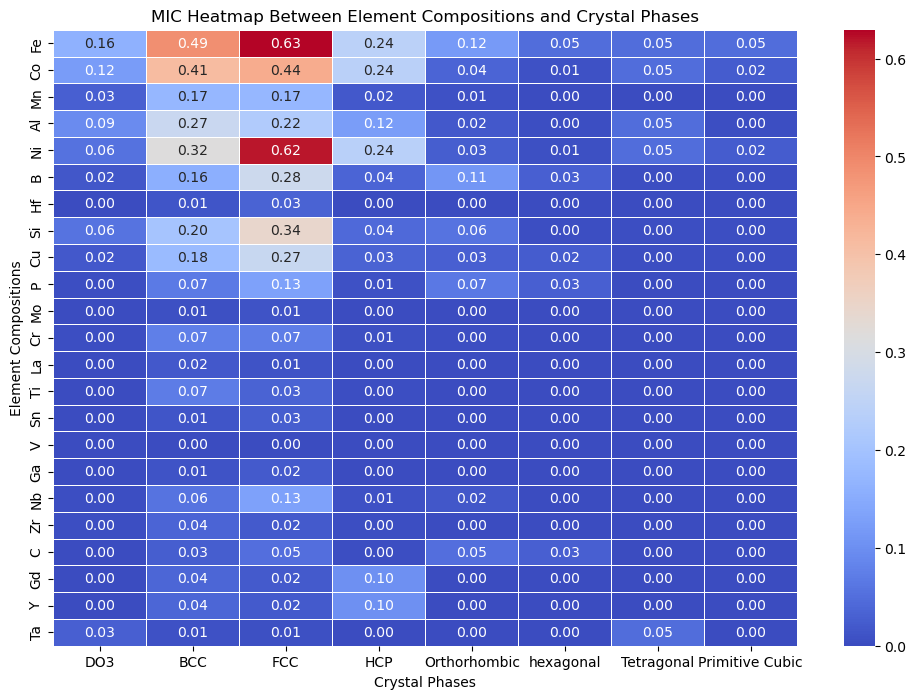

In [7]:
# 画元素成分 & 晶体相之间的 MIC 热力图
plt.figure(figsize=(12, 8))
sns.heatmap(mic_df.loc[element_columns, crystal_phase_columns], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("MIC Heatmap Between Element Compositions and Crystal Phases")
plt.xlabel("Crystal Phases")
plt.ylabel("Element Compositions")
plt.savefig('mic_heatmap元素-晶体结构.png', dpi=300, bbox_inches='tight')
plt.show()

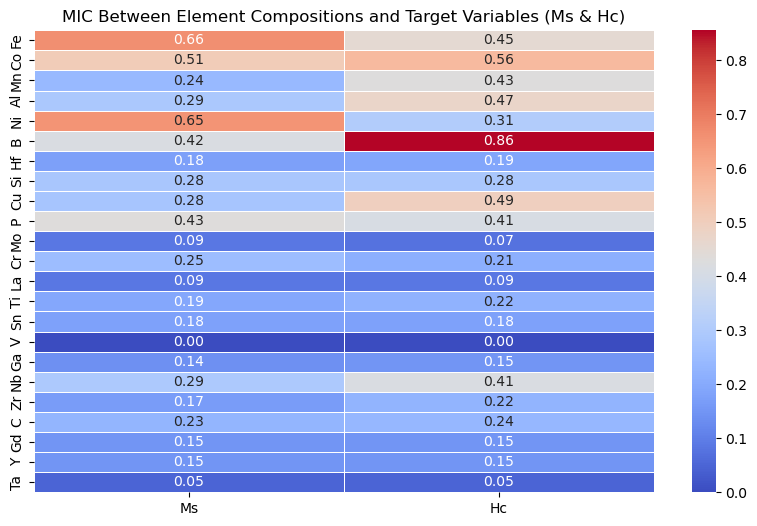

In [8]:
# **2. 画元素成分 & 目标变量的 MIC 热力图**
plt.figure(figsize=(10, 6))
sns.heatmap(mic_df.loc[element_columns, target_columns], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("MIC Between Element Compositions and Target Variables (Ms & Hc)")
plt.savefig('mic_heatmap元素-性能.png', dpi=300, bbox_inches='tight')
plt.show()

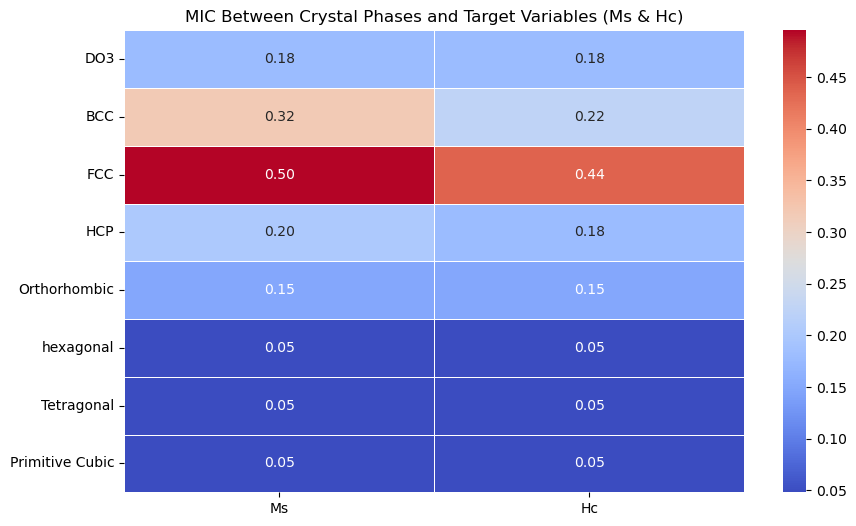

In [9]:
# **3. 画晶体相 & 目标变量的 MIC 热力图**
plt.figure(figsize=(10, 6))
sns.heatmap(mic_df.loc[crystal_phase_columns, target_columns], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("MIC Between Crystal Phases and Target Variables (Ms & Hc)")
plt.savefig('mic_heatmap性能-晶体结构.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# # **4. MIC 相关性排序**
# mic_target = mic_df[target_columns].drop(index=target_columns)  # 去掉 Ms, Hc 自己的行
# mic_sorted = mic_target.sort_values(by=["Ms", "Hc"], ascending=False)  # 按 MIC 降序排列

# print("🔹 Ms 和 Hc 的非线性相关性排名（MIC）：")
# print(mic_sorted)

# 计算 MIC 相关性矩阵（只针对元素成分部分）
mic_element = mic_df.loc[element_columns, target_columns]  # 提取元素成分和目标变量部分

# MIC 排序（按 Ms 和 Hc 排序）
mic_sorted_elements = mic_element.sort_values(by=["Ms", "Hc"], ascending=False)  # 按 MIC 降序排列

# 输出 MIC 排序结果
print("🔹 Ms 和 Hc 的非线性相关性排名（MIC）：")
print(mic_sorted_elements)

🔹 Ms 和 Hc 的非线性相关性排名（MIC）：
          Ms        Hc
Fe  0.592421  0.447654
Ni  0.570239  0.309006
Co  0.483350  0.493621
P   0.375211  0.383388
B   0.350244  0.769965
Al  0.302777  0.426073
Cu  0.265697  0.420222
Cr  0.263290  0.209223
Nb  0.257015  0.392939
Mn  0.249016  0.370912
Si  0.240565  0.292919
C   0.217885  0.219104
Ti  0.183332  0.208115
Ga  0.178403  0.187159
Hf  0.164492  0.173248
Zr  0.161030  0.213789
Sn  0.158193  0.158193
Gd  0.132551  0.132551
Y   0.132551  0.132551
Mo  0.132551  0.123334
La  0.075554  0.075554
V   0.075554  0.075554
Ta  0.042401  0.042401


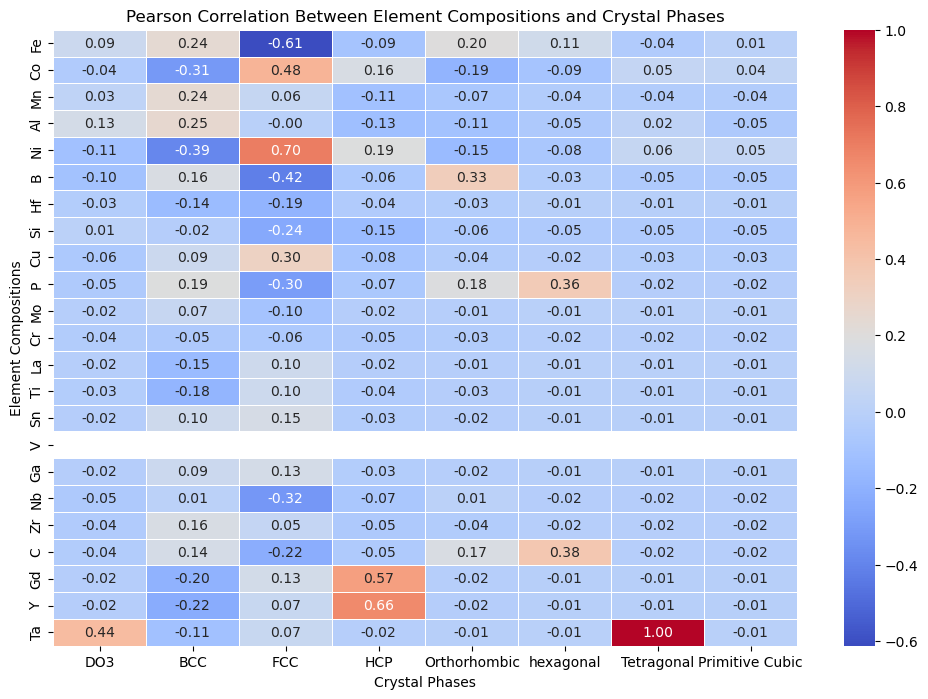

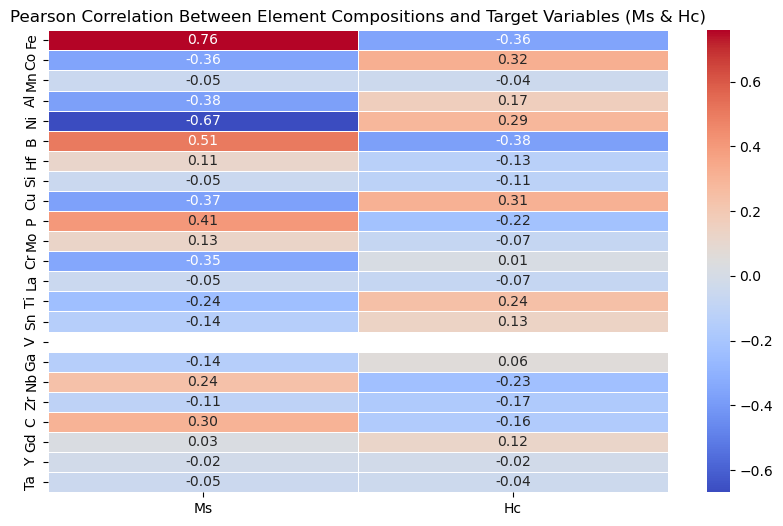

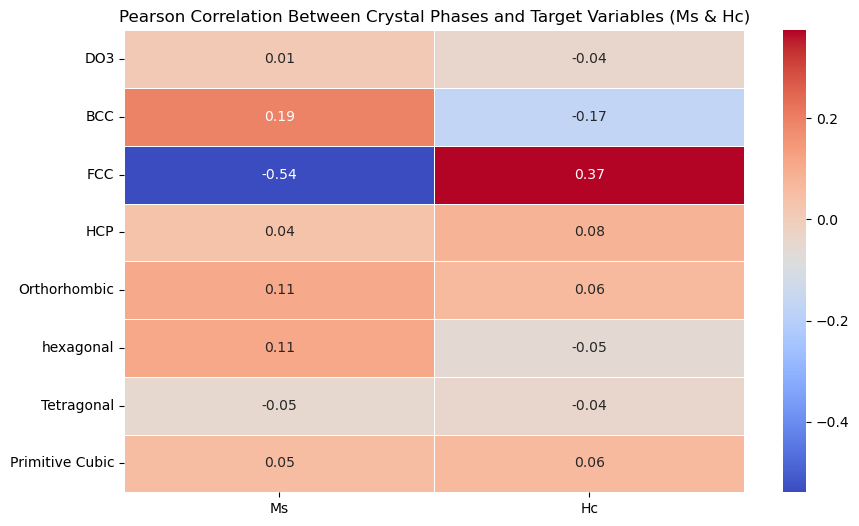

In [10]:
# 计算 Pearson 相关系数矩阵
pearson_corr = data.corr()

# 转换为 DataFrame 方便可视化
pearson_df = pd.DataFrame(pearson_corr, index=feature_columns, columns=feature_columns)

# 画元素成分 & 晶体相之间的 Pearson 相关性热力图
plt.figure(figsize=(12, 8))
sns.heatmap(pearson_df.loc[element_columns, crystal_phase_columns], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Between Element Compositions and Crystal Phases")
plt.xlabel("Crystal Phases")
plt.ylabel("Element Compositions")
plt.savefig('element_crystal_pearson_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# **2. 画元素成分 & 目标变量的 Pearson 相关性热力图**
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_df.loc[element_columns, target_columns], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Between Element Compositions and Target Variables (Ms & Hc)")
plt.savefig('element_target_pearson_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# **3. 画晶体相 & 目标变量的 Pearson 相关性热力图**
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_df.loc[crystal_phase_columns, target_columns], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Between Crystal Phases and Target Variables (Ms & Hc)")
plt.savefig('crystal_target_pearson_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()



In [11]:
# 计算 Pearson 相关性矩阵（只针对元素成分部分）
pearson_element = pearson_df.loc[element_columns, target_columns]  # 提取元素成分和目标变量部分

# Pearson 相关性排序（按 Ms 和 Hc 排序）
pearson_sorted_elements = pearson_element.sort_values(by=["Ms", "Hc"], ascending=False)  # 按 Pearson 相关性降序排列

# 输出 Pearson 排序结果
print("🔹 Ms 和 Hc 的线性相关性排名（Pearson）：")
print(pearson_sorted_elements)


🔹 Ms 和 Hc 的线性相关性排名（Pearson）：
          Ms        Hc
Fe  0.711422 -0.336708
B   0.451568 -0.221451
P   0.375306 -0.185624
C   0.282872 -0.138196
Nb  0.221127 -0.200493
Hf  0.107074 -0.114121
Gd  0.028149  0.007555
Mo  0.015782  0.225900
Y  -0.012077 -0.057169
Ta -0.043347 -0.042081
La -0.044336 -0.064484
Si -0.053931 -0.140710
V  -0.076086  0.174406
Zr -0.093138 -0.151631
Mn -0.099522  0.073472
Sn -0.127834  0.006510
Ga -0.135087  0.182347
Co -0.185436  0.410986
Ti -0.228535  0.125249
Al -0.331379  0.047614
Cr -0.371186  0.031882
Cu -0.392022  0.147717
Ni -0.646695  0.109031


重要性分析

In [11]:
# 读取数据
file_path = 'cleaned_data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# 定义特征
element_columns = ['Fe', 'Co', 'Mn', 'Al', 'Ni', 'B', 'Hf', 'Si', 'Cu', 'P', 'Mo', 'Cr',
       'La', 'Ti', 'Sn', 'V', 'Ga', 'Nb', 'Zr', 'C', 'Gd', 'Y', 'Ta']
crystal_phase_columns = ['DO3',
       'BCC', 'FCC', 'HCP', 'Orthorhombic', 'hexagonal', 'Tetragonal',
       'Primitive Cubic']
target_columns = ['Ms', 'Hc']

In [12]:
# 选择自变量（元素成分 + 晶体相）和目标变量
X = data[element_columns]
y_Ms = data['Ms']
y_Hc = data['Hc']

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# 训练随机森林模型并进行 SHAP 解释
def shap_analysis(X, y, feature_names, target_name, maximize=True):
    """
    SHAP 重要性分析：
    - maximize=True  ->  寻找增大目标变量的因素（如 Ms）
    - maximize=False ->  寻找降低目标变量的因素（如 Hc）
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 模型评估
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model evaluation for {target_name}:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # 计算 SHAP 值
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # 计算平均 SHAP 值
    mean_shap = np.mean(shap_values, axis=0)

    # 对 Ms: 找出正 SHAP 值的特征（提升 Ms）
    # 对 Hc: 找出负 SHAP 值的特征（降低 Hc）
    if maximize:
        sorted_indices = np.argsort(-mean_shap)  # Ms 越大越好，按贡献度从高到低排序
    else:
        sorted_indices = np.argsort(mean_shap)  # Hc 越小越好，按贡献度从低到高排序

    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_shap_values = mean_shap[sorted_indices]

    # 输出特征重要性数据
    feature_importance_df = pd.DataFrame({
        'Feature': sorted_features,
        'SHAP Value': sorted_shap_values
    })
    print(f"Feature importance for {target_name}:")
    print(feature_importance_df)

    # 画 SHAP 重要性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_shap_values, y=sorted_features, palette='coolwarm')
    plt.xlabel("SHAP Value")
    plt.ylabel("Feature")
    plt.title(f"Optimized SHAP Feature Importance for {target_name} ({'Max' if maximize else 'Min'})")
    # 保存图片
    file_name = f"{target_name}_shap_importance.png"
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()


Model evaluation for Ms:
Mean Squared Error: 635.5882645136256
R-squared: 0.8006496940102505
Feature importance for Ms:
   Feature  SHAP Value
0       Fe    3.639710
1       Ni    2.287075
2        B    0.540445
3       Nb    0.484690
4        P    0.395672
5       Cu    0.339346
6       Zr    0.216611
7       Hf    0.114464
8       Ti    0.114461
9       Ga    0.021577
10      Mo    0.017834
11       C    0.000029
12       V    0.000000
13      Ta    0.000000
14      La   -0.002765
15      Sn   -0.005637
16      Cr   -0.025923
17       Y   -0.096984
18      Gd   -0.126718
19      Si   -0.242314
20      Mn   -0.360877
21      Al   -0.496796
22      Co   -1.187407


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4532\1361759009.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_shap_values, y=sorted_features, palette='coolwarm')


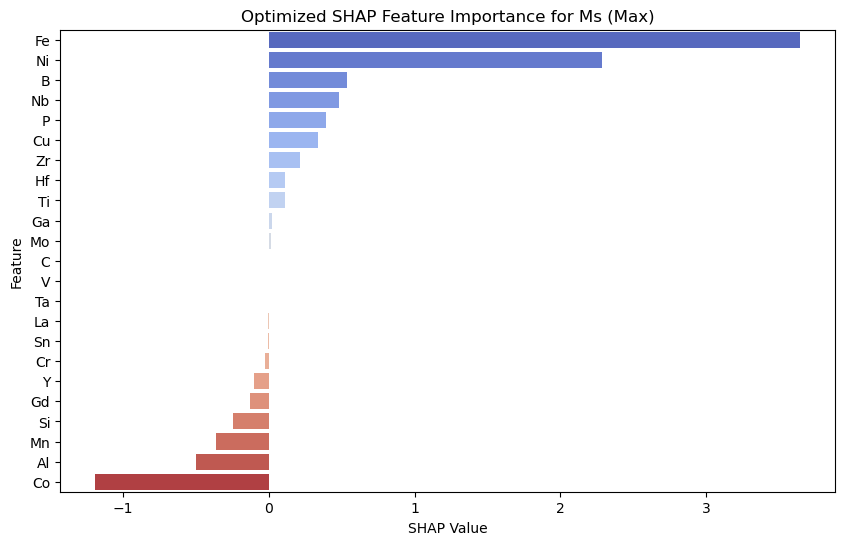

Model evaluation for Hc:
Mean Squared Error: 109959.64563438331
R-squared: 0.09553278032416057
Feature importance for Hc:
   Feature  SHAP Value
0        B -127.214101
1       Ti  -16.380251
2       Cu  -15.313729
3       Al   -6.521138
4       Gd   -5.717525
5       Cr   -5.219011
6       Ni   -3.790880
7       Mn   -3.656074
8       Ga   -1.182209
9       Sn   -0.762340
10      Hf   -0.346266
11      Zr   -0.316375
12       V    0.000000
13      Ta    0.000000
14      Mo    0.001968
15       C    0.009760
16      La    0.012937
17       P    0.212568
18      Nb    0.363989
19       Y    0.455971
20      Si    2.748076
21      Fe   27.841748
22      Co   39.805052


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4532\1361759009.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_shap_values, y=sorted_features, palette='coolwarm')


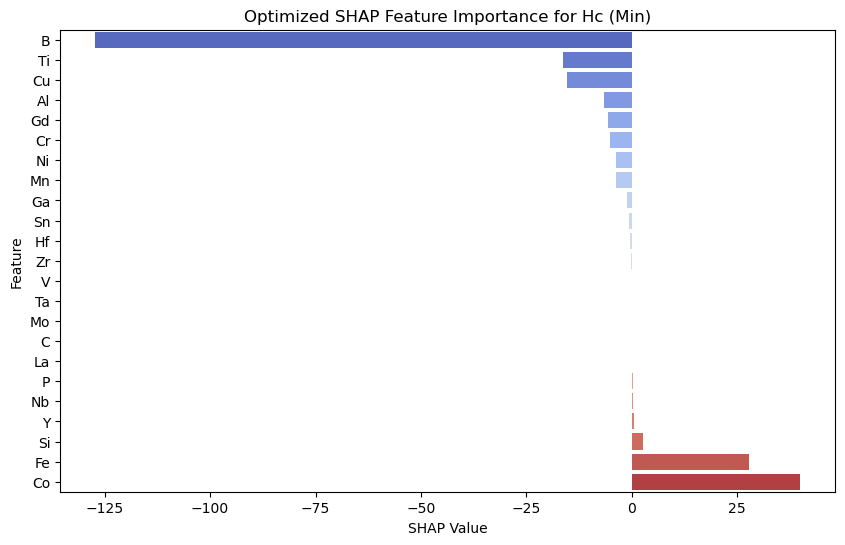

In [14]:
# 对 Ms 进行 SHAP 分析
shap_analysis(X_scaled, y_Ms, element_columns, 'Ms', maximize=True)

# 对 Hc 进行 SHAP 分析
shap_analysis(X_scaled, y_Hc, element_columns, 'Hc', maximize=False)